In [ ]:
!pip uninstall -y numpy
!pip install numpy==1.26.4

Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 66.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [ ]:
print("NumPy version:", np.__version__)

NumPy version: 2.0.2


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!pip install gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 31.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 10.5 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.14.1
    Uninstalling scipy-1.14.1:
      Successfully uninstalled scipy-1.14.1


In [ ]:
#Load pre-trained GloVe embeddings
# import gensim.downloader as api
from gensim.models import KeyedVectors

embedding_path = "/content/drive/MyDrive/Embeddings/glove-wiki-gigaword-100/glove-wiki-gigaword-100.gz"
embeddings = KeyedVectors.load_word2vec_format(embedding_path, binary=False)
# glove_model = api.load("glove-wiki-gigaword-100")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
import os
from pathlib import Path
import requests
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image, ImageDraw, ImageFont
import seaborn as sns
import numpy as np
import ast
import warnings
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
# warnings.filterwarnings('ignore', category= Warning)
import json
import cuda
# Import required modules
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import f1_score
import requests
from sklearn.preprocessing import MultiLabelBinarizer
import time
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#for text preprocessing
import re
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
#List of stops words in English
from nltk.corpus import stopwords
#stopwords.words('english')
nltk.download('wordnet')
lemma = WordNetLemmatizer()

#Fetching Data

In [ ]:
# Set local paths
csv_path = 'movie_metadata.csv'
# poster_dir = 'movie_posters'

# Check if data already exists
if os.path.exists(csv_path): #and os.path.exists(poster_dir):
    print("Posters and CSV file already downloaded, skipping data acquisition.")
else:
    # Fetch genre list
    API_KEY = 'd987d81a646fa33f4795a26f25fe7851'  # Replace with actual key
    genres_url = f'https://api.themoviedb.org/3/genre/movie/list?api_key={API_KEY}'
    genres_response = requests.get(genres_url)
    genre_map = {genre['id']: genre['name'] for genre in genres_response.json()['genres']}

    # Fetch movies until we have at least 50000 valid ones
    movies = []
    page = 1
    years = list(range(2000, 2025))  # You can expand this if needed

    for year in years:
        for page in range(1, 501):  # Max 500 pages per discover query
            if len(movies) >= 50000:
                break
            discover_url = (
                f'https://api.themoviedb.org/3/discover/movie?api_key={API_KEY}'
                f'&language=en-US&sort_by=popularity.desc&include_adult=false'
                f'&include_video=false&page={page}&primary_release_year={year}'
            )
            response = requests.get(discover_url)
            data = response.json()

            if 'results' not in data:
                print(f"Year {year}, Page {page} failed. Response: {data}")
                break

            for movie in data['results']:
                if movie.get('overview') and movie.get('poster_path'):
                    movie['genres'] = [genre_map.get(id, 'Unknown') for id in movie['genre_ids']]
                    movie['year'] = year
                    movies.append(movie)
        page += 1
        if page > 1000:  # Safety limit
            break

    # Create local directory for posters
    # os.makedirs(poster_dir, exist_ok=True)



KeyError: 'tagline'

In [ ]:
 # Download posters and create DataFrame
movies_data = []
for movie in tqdm(movies[:50000], desc="Downloading movie dataset"):
    # poster_url = f'https://image.tmdb.org/t/p/w500{movie["poster_path"]}'
    # poster_file = os.path.join(poster_dir, f'{movie["id"]}.jpg')
    # response = requests.get(poster_url)
    # with open(poster_file, 'wb') as f:
    #     f.write(response.content)
    movie_data = {
        'movie_id': movie['id'],
        'title': movie['title'],
        'overview': movie['overview'],
        'genres': movie['genres'],
        'vote_avg': movie['vote_average'],
        'year' : movie['year']
    }
    movies_data.append(movie_data)

df = pd.DataFrame(movies_data)
df.to_csv(csv_path, index=False)

In [ ]:
# Fetch genre list
API_KEY = 'd987d81a646fa33f4795a26f25fe7851'  # Replace with actual key
genres_url = f'https://api.themoviedb.org/3/genre/movie/list?api_key={API_KEY}'
genres_response = requests.get(genres_url)
genre_map = {genre['id']: genre['name'] for genre in genres_response.json()['genres']}

In [ ]:
csv_path = 'movie_metadata.csv'
df = pd.read_csv('movie_metadata.csv')

In [ ]:
if isinstance(df['genres'].iloc[0], str):
    df['genres'] = df['genres'].str.strip("[]").str.replace("'", "").str.split(", ")

##Clean Data
1. Select required columns, parse JSON fields, and add poster placeholder
2. We may add director column later on if we find certain patterns like if some directors specialize in specific genres, using learning embedding for directors.
3. `pd.notnull(x)` → Ensures x is not NaN (missing). If it's missing, it assigns an empty list [] instead.
4. `parse_json(x)` → Converts the JSON-like string into a Python list or dictionary.

In [ ]:
df['genres'] = df['genres'].apply(lambda x: None if x == [''] else x)
df = df.dropna(subset=['genres']).reset_index(drop=True)

In [ ]:
def clean_data(merged_df):
    selected_cols = ['movie_id', 'title', 'genres', 'overview', 'year', 'vote_avg']
    df = merged_df[selected_cols].copy()
    df.rename(columns={'movie_id': 'id'}, inplace=True)
    selected_cols = ['id', 'title', 'genres', 'overview', 'year', 'vote_avg']

    print(f'Entries from dataset: {df.shape[0]}')
    df = df.drop_duplicates(['title']).reset_index(drop=True)
    print(f"Entries without duplicates: {df.shape[0]}")
    df = df[selected_cols].dropna().reset_index(drop=True)
    print(f"Entries from cleaned data: {df.shape[0]}")
    print(f"Movies columns: {df.columns.tolist()}")

    # df['genres'] = df['genres'].apply(lambda x: parse_json(x) if pd.notnull(x) else [])
    return df

In [ ]:
available_genres = [genre for genre in common_genres if genre in final_df.columns]
print(available_genres)

['Drama', 'Comedy', 'Documentary', 'Romance', 'Action', 'Thriller', 'Horror', 'Crime', 'Music', 'Animation', 'TV Movie', 'Family']


In [ ]:
df = clean_data(df)

Entries from dataset: 42010
Entries without duplicates: 40558
Entries from cleaned data: 40558
Movies columns: ['id', 'title', 'genres', 'overview', 'year', 'vote_avg']


In [ ]:
mlb = MultiLabelBinarizer(classes=list(genre_map.values()))
genre_matrix = mlb.fit_transform(df['genres'])
genre_df = pd.DataFrame(genre_matrix, columns=mlb.classes_)
# genre_df = genre_df.astype(int)
final_df = pd.concat([df, genre_df], axis=1)

In [ ]:
row = df.iloc[[40557]]
print(row)

           id                                 title   genres  \
40557  200437  Yngwie Malmsteen: Far Beyond the Sun  [Music]   

                                                overview  year  vote_avg  
40557  Inspired by the flamboyance of Hendrix, the di...  2007       7.5  


In [ ]:
final_df[mlb.classes_] = final_df[mlb.classes_].astype(int)

In [ ]:
print(final_df.columns.tolist())

['id', 'title', 'genres', 'overview', 'year', 'vote_avg', 'Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'History', 'Horror', 'Music', 'Mystery', 'Romance', 'Science Fiction', 'TV Movie', 'Thriller', 'War', 'Western']


In [ ]:
final_df.head()

,id,title,genres,overview,year,vote_avg,Action,Adventure,Animation,Comedy,...,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
0,98,Gladiator,"[Action, Drama, Adventure]","After the death of Emperor Marcus Aurelius, hi...",2000,8.218,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9532,Final Destination,[Horror],After a teenager has a terrifying vision of hi...,2000,6.608,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,4247,Scary Movie,[Comedy],A familiar-looking group of teenagers find the...,2000,6.363,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,11688,The Emperor's New Groove,"[Adventure, Animation, Comedy, Family, Fantasy]",When self-centered Emperor Kuzco is turned int...,2000,7.600,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
4,77,Memento,"[Mystery, Thriller]",Leonard Shelby is tracking down the man who ra...,2000,8.178,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40558 entries, 0 to 40557
Data columns (total 25 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               40558 non-null  int64  
 1   title            40558 non-null  object 
 2   genres           40558 non-null  object 
 3   overview         40558 non-null  object 
 4   year             40558 non-null  int64  
 5   vote_avg         40558 non-null  float64
 6   Action           40558 non-null  int64  
 7   Adventure        40558 non-null  int64  
 8   Animation        40558 non-null  int64  
 9   Comedy           40558 non-null  int64  
 10  Crime            40558 non-null  int64  
 11  Documentary      40558 non-null  int64  
 12  Drama            40558 non-null  int64  
 13  Family           40558 non-null  int64  
 14  Fantasy          40558 non-null  int64  
 15  History          40558 non-null  int64  
 16  Horror           40558 non-null  int64  
 17  Music       

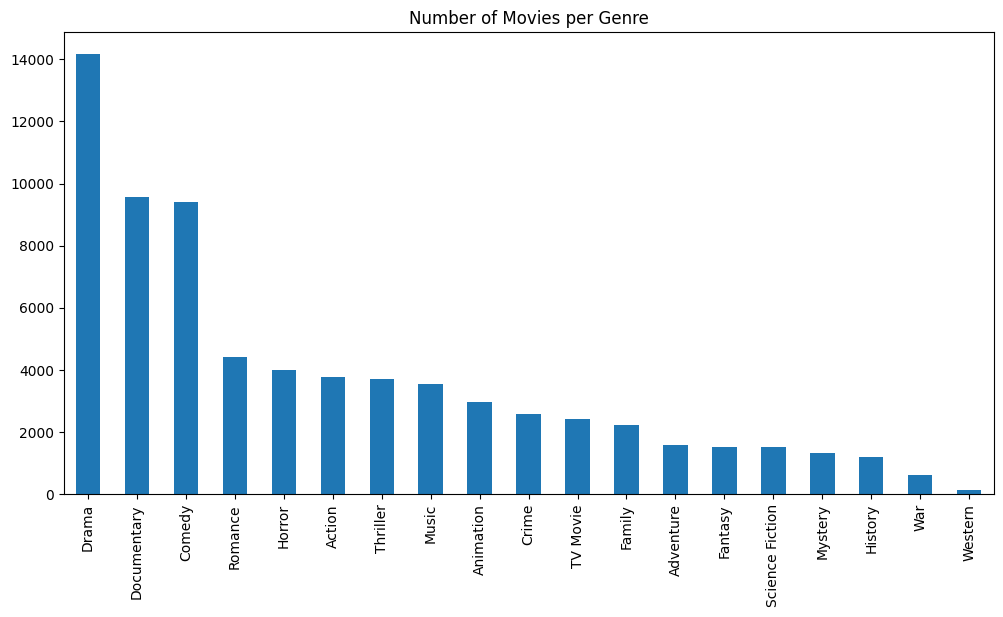

In [ ]:
# Check basic info
print(final_df.info())
print(final_df.describe())
print(final_df.isnull().sum())

# Genre distribution
genre_columns = [col for col in final_df.columns if col not in ['id', 'title', 'overview', 'genres','vote_avg','year']]
genre_counts = final_df[genre_columns].sum().sort_values(ascending=False)
plt.figure(figsize=(12, 6))
genre_counts.plot(kind='bar')
plt.title('Number of Movies per Genre')
plt.show()

###Count all possible genre pairs

In [ ]:
genre_pairs=[pair for pair in final_df['genres']]

In [ ]:
genre_pairs

[['Action', 'Drama', 'Adventure'],
 ['Horror'],
 ['Comedy'],
 ['Adventure', 'Animation', 'Comedy', 'Family', 'Fantasy'],
 ['Mystery', 'Thriller'],
 ['Thriller', 'Drama', 'Crime'],
 ['Adventure', 'Action', 'Thriller'],
 ['Comedy', 'Romance'],
 ['Adventure', 'Drama'],
 ['Comedy', 'Drama', 'Romance'],
 ['Drama', 'History', 'War', 'Action'],
 ['Family', 'Comedy', 'Fantasy'],
 ['Crime', 'Comedy'],
 ['Comedy'],
 ['Thriller', 'Drama', 'Mystery'],
 ['Animation', 'Family', 'Adventure'],
 ['Family', 'Adventure', 'Animation', 'Comedy', 'Fantasy'],
 ['Drama'],
 ['Drama'],
 ['Crime', 'Drama'],
 ['Comedy', 'Adventure'],
 ['Drama', 'Romance'],
 ['Animation', 'Comedy', 'Family'],
 ['Action', 'Adventure', 'Comedy', 'Crime', 'Thriller'],
 ['Horror', 'Mystery'],
 ['Comedy', 'Romance'],
 ['Drama', 'Comedy', 'Music'],
 ['Drama'],
 ['Crime', 'Comedy'],
 ['Animation', 'Fantasy', 'Horror', 'Action', 'Adventure', 'Science Fiction'],
 ['Action', 'Science Fiction', 'Thriller'],
 ['Comedy', 'Crime', 'Action'],
 [

In [ ]:
from itertools import combinations
genres = [pair for pair in final_df['genres']]
#get all genre tags in a list
all_genres = sum(genres,[])
total_genres = len(set(all_genres))
total_genres

#Create a dictionary of genres using FreqDist form nltk library and their occurence count across the dataset
all_genres = nltk.FreqDist(all_genres)

all_genres_df = pd.DataFrame({'Genre': list(all_genres.keys()),
                              'Count': list(all_genres.values())
})

# Flatten genres and get unique list
all_genres = set(sum(final_df['genres'], []))
genre_pairs = list(combinations(all_genres, 1))  # All 2-genre combinations
# genre_pairs=[pair for pair in final_df['genres']]
# Count co-occurrences for each pair
cooccurrence_counts = {}
for pair in genre_pairs:
    count = final_df['genres'].apply(
        lambda x: set(pair).issubset(x)
    ).sum()
    cooccurrence_counts[pair] = count

# Display sorted results
import pprint
pprint.pprint(sorted(cooccurrence_counts.items(), key=lambda x: -x[1]))

[(('Drama',), 14167),
 (('Documentary',), 9552),
 (('Comedy',), 9420),
 (('Romance',), 4427),
 (('Horror',), 3983),
 (('Action',), 3776),
 (('Thriller',), 3693),
 (('Music',), 3531),
 (('Animation',), 2960),
 (('Crime',), 2570),
 (('TV Movie',), 2405),
 (('Family',), 2235),
 (('Adventure',), 1582),
 (('Fantasy',), 1521),
 (('Science Fiction',), 1506),
 (('Mystery',), 1333),
 (('History',), 1181),
 (('War',), 605),
 (('Western',), 143)]


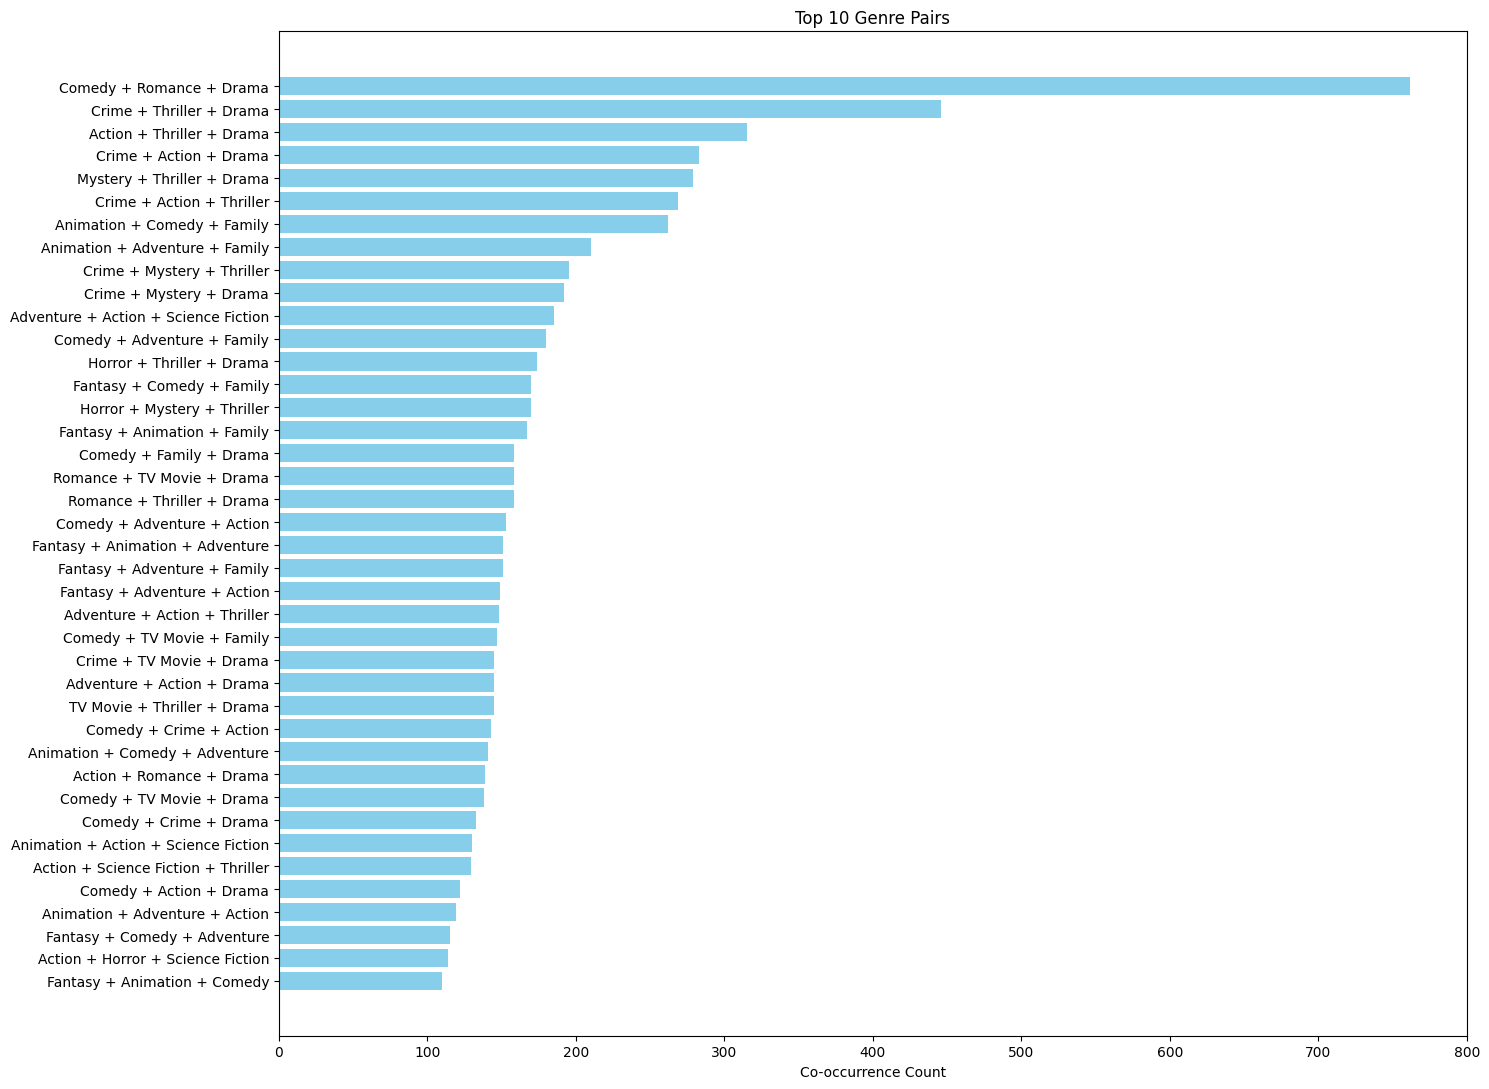

In [ ]:
# Sort pairs by count and select top 10
top_pairs = sorted(cooccurrence_counts.items(), key=lambda x: -x[1])[:40]
genres, counts = zip(*top_pairs)  # Unzip pairs

# Plot
plt.figure(figsize=(15, 11))
plt.barh(
    [f"{g[0]} + {g[1]} + {g[2]}" for g in genres],
    counts,
    color='skyblue'
)
plt.xlabel("Co-occurrence Count")
plt.title("Top 10 Genre Pairs")
plt.gca().invert_yaxis()  # Highest count at top
plt.tight_layout()
plt.show()

In [ ]:
top_pairs

[(('Comedy', 'Romance', 'Drama'), 762),
 (('Crime', 'Thriller', 'Drama'), 446),
 (('Action', 'Thriller', 'Drama'), 315),
 (('Crime', 'Action', 'Drama'), 283),
 (('Mystery', 'Thriller', 'Drama'), 279),
 (('Crime', 'Action', 'Thriller'), 269),
 (('Animation', 'Comedy', 'Family'), 262),
 (('Animation', 'Adventure', 'Family'), 210),
 (('Crime', 'Mystery', 'Thriller'), 195),
 (('Crime', 'Mystery', 'Drama'), 192),
 (('Adventure', 'Action', 'Science Fiction'), 185),
 (('Comedy', 'Adventure', 'Family'), 180),
 (('Horror', 'Thriller', 'Drama'), 174),
 (('Fantasy', 'Comedy', 'Family'), 170),
 (('Horror', 'Mystery', 'Thriller'), 170),
 (('Fantasy', 'Animation', 'Family'), 167),
 (('Comedy', 'Family', 'Drama'), 158),
 (('Romance', 'TV Movie', 'Drama'), 158),
 (('Romance', 'Thriller', 'Drama'), 158),
 (('Comedy', 'Adventure', 'Action'), 153),
 (('Fantasy', 'Animation', 'Adventure'), 151),
 (('Fantasy', 'Adventure', 'Family'), 151),
 (('Fantasy', 'Adventure', 'Action'), 149),
 (('Adventure', 'Action

Number of genres per movie statistics:
count    40558.000000
mean         1.546403
std          0.772620
min          0.000000
25%          1.000000
50%          1.000000
75%          2.000000
max          6.000000
Name: num_genres, dtype: float64


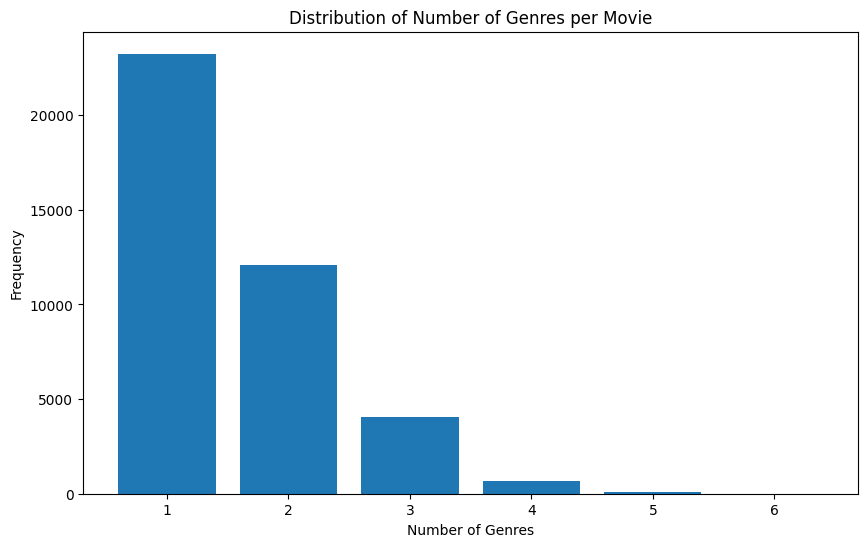

In [ ]:
# Enhanced EDA: Number of Genres per Movie
import matplotlib.pyplot as plt
common_genres = ['Action', 'Animation', 'Comedy', 'Crime',
                 'Documentary', 'Drama', 'Family', 'Horror', 'Music',
                 'Romance', 'TV Movie', 'Thriller']
# Calculate number of genres per movie
final_df['num_genres'] = final_df[common_genres].sum(axis=1)

# Plot histogram
plt.figure(figsize=(10,6))
plt.hist(final_df['num_genres'], bins=range(1, final_df['num_genres'].max()+2), align='left', rwidth=0.8)
plt.title('Distribution of Number of Genres per Movie')
plt.xlabel('Number of Genres')
plt.ylabel('Frequency')
plt.xticks(range(1, final_df['num_genres'].max()+1))
plt.savefig('num_genres_histogram.png')

# Print statistics
print("Number of genres per movie statistics:")
print(final_df['num_genres'].describe())

# Enhanced EDA: Genre Co-occurrence Matrix
import seaborn as sns

# Compute co-occurrence matrix
co_occurrence = final_df[common_genres].T.dot(final_df[common_genres])

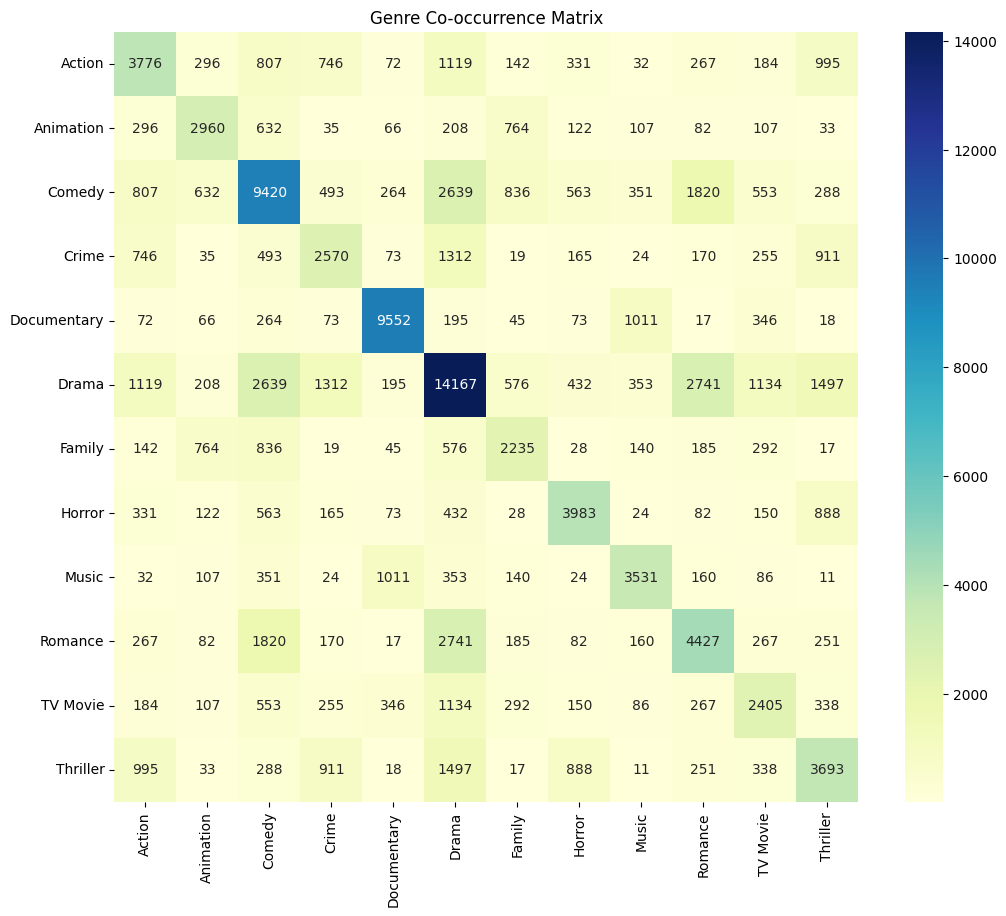

In [ ]:
# Plot heatmap showing relation between genres
plt.figure(figsize=(12,10))
sns.heatmap(co_occurrence, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Genre Co-occurrence Matrix')
plt.savefig('genre_cooccurrence_heatmap.png')

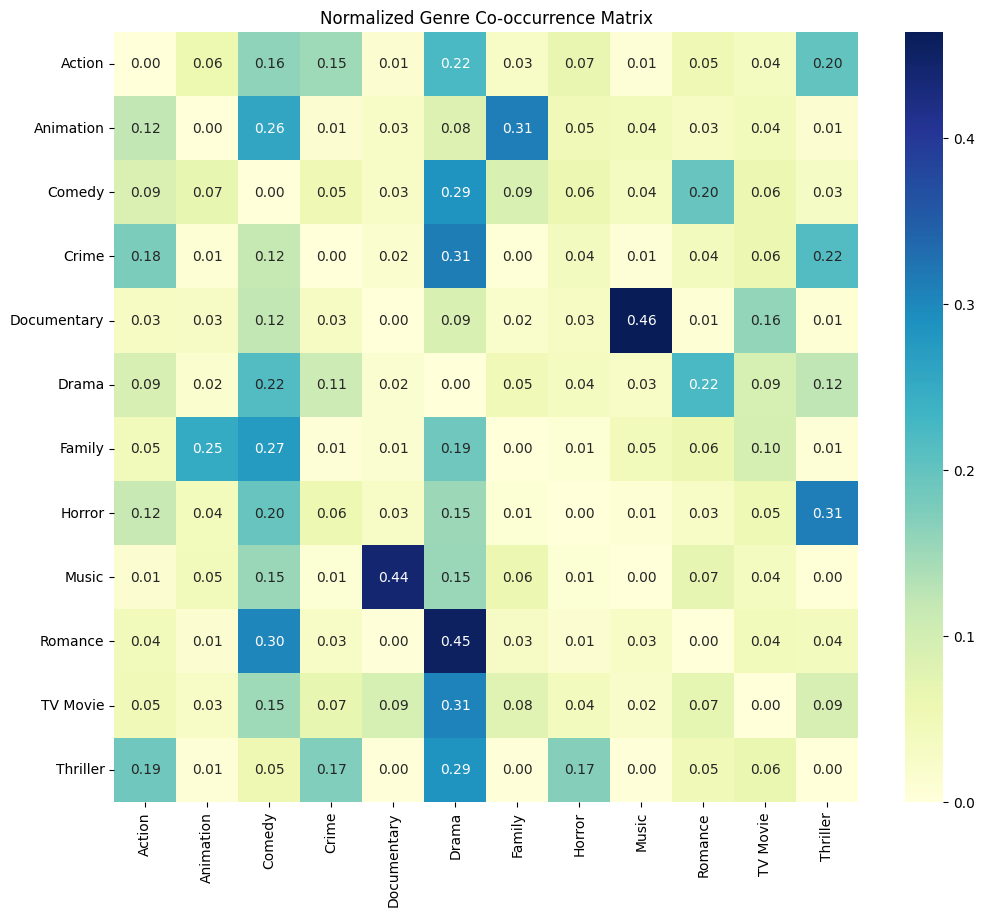

In [ ]:
# 3. Extended Genre Co-occurrence Matrix with Normalization
co_occurrence = final_df[common_genres].T.dot(final_df[common_genres])
np.fill_diagonal(co_occurrence.values, 0)  # Remove self-co-occurrences
co_occurrence_normalized = co_occurrence.div(co_occurrence.sum(axis=1), axis=0)
plt.figure(figsize=(12, 10))
sns.heatmap(co_occurrence_normalized, annot=True, fmt='.2f', cmap='YlGnBu')
plt.title('Normalized Genre Co-occurrence Matrix')
plt.savefig('normalized_genre_cooccurrence.png')

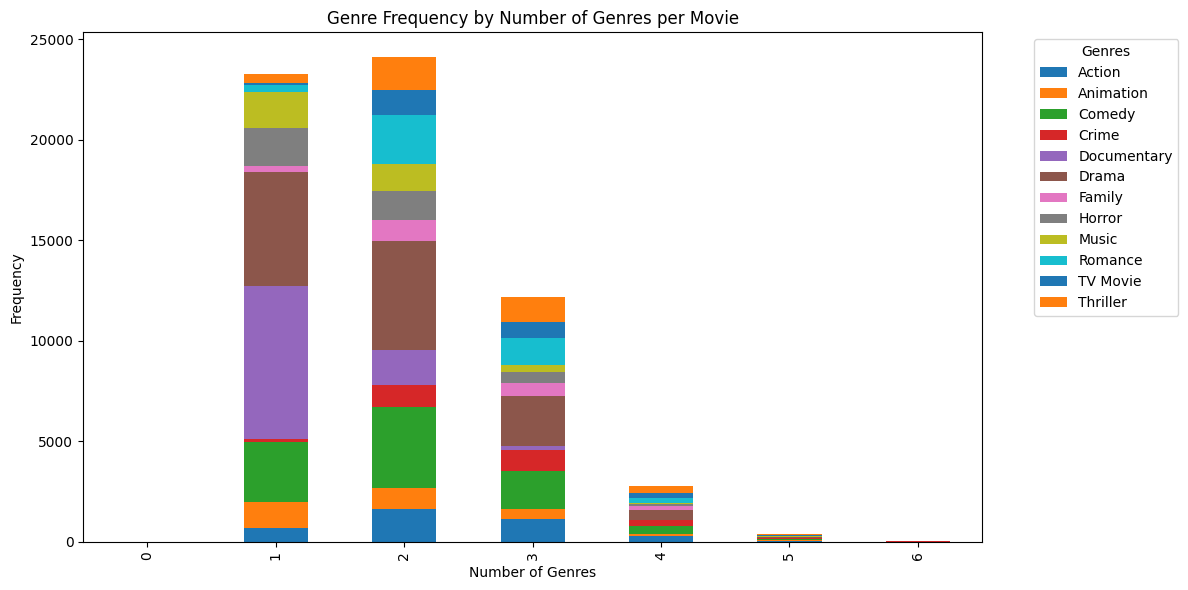

In [ ]:
import matplotlib.pyplot as plt
#Shows mapping frequency of movies in genres  there
genre_freq_by_count = final_df.groupby('num_genres')[common_genres].sum()
genre_freq_by_count.plot(kind='bar', stacked=True, figsize=(12,6))
plt.title('Genre Frequency by Number of Genres per Movie')
plt.xlabel('Number of Genres')
plt.ylabel('Frequency')
plt.legend(title='Genres', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('genre_freq_by_count.png')

In [ ]:
# Block U1: Compute Drop Probabilities for Majority Genres

import numpy as np
import pandas as pd
import scipy.stats as stats

# Define target count for majority genres (choose a value that reduces the skew)
target = 5000

# Ensure common_genres is defined
common_genres = ['Drama', 'Comedy', 'Documentary', 'Romance',
                 'Action', 'Thriller', 'Horror', 'Crime',
                 'Music', 'Animation', 'TV Movie', 'Family']

# Calculate final genre counts from final_df
final_counts = final_df[common_genres].sum().sort_values(ascending=False)
print("Original Genre Distribution:")
print(final_counts)

# Calculate drop probability for each genre: only if count > target
drop_prob_dict = {}
for genre, count in final_counts.items():
    if count > target:
        drop_prob_dict[genre] = 1 - (target / count)
    else:
        drop_prob_dict[genre] = 0

print("\nDrop Probabilities per Genre:")
for genre, p in drop_prob_dict.items():
    print(f"{genre}: {p:.3f}")

Original Genre Distribution:
Drama          14167
Documentary     9552
Comedy          9420
Romance         4427
Horror          3983
Action          3776
Thriller        3693
Music           3531
Animation       2960
Crime           2570
TV Movie        2405
Family          2235
dtype: int64

Drop Probabilities per Genre:
Drama: 0.647
Documentary: 0.477
Comedy: 0.469
Romance: 0.000
Horror: 0.000
Action: 0.000
Thriller: 0.000
Music: 0.000
Animation: 0.000
Crime: 0.000
TV Movie: 0.000
Family: 0.000


In [ ]:
# Block U2: Apply Undersampling to Reduce Overrepresentation

import numpy as np

# Function to compute the maximum drop probability for a row based on its majority labels
def compute_row_drop_probability(row):
    probs = []
    for genre in common_genres:
        # Check if row has this genre and if the drop probability for the genre is greater than 0
        if row[genre] == 1 and drop_prob_dict[genre] > 0:
            probs.append(drop_prob_dict[genre])
    return max(probs) if probs else 0

# Set random seed for reproducibility
np.random.seed(42)

# Apply undersampling: retain a row with probability = 1 - (max drop probability for that row)
mask = final_df.apply(lambda row: np.random.uniform(0,1) >= compute_row_drop_probability(row), axis=1)
df_under = final_df[mask].copy()

print("\nUndersampled dataset shape:", df_under.shape)

# Calculate the new genre distribution after undersampling
new_genre_counts_under = df_under[common_genres].sum().sort_values(ascending=False)
print("\nNew Genre Distribution After Undersampling:")
print(new_genre_counts_under)


Undersampled dataset shape: (23866, 26)

New Genre Distribution After Undersampling:
Documentary    5022
Drama          4962
Comedy         4560
Horror         3413
Music          2715
Action         2680
Thriller       2608
Animation      2490
Romance        2157
Crime          1503
Family         1490
TV Movie       1316
dtype: int64


<ipython-input-114-cff9b8959a29>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=new_genre_counts_under.index, y=new_genre_counts_under.values, palette='viridis')


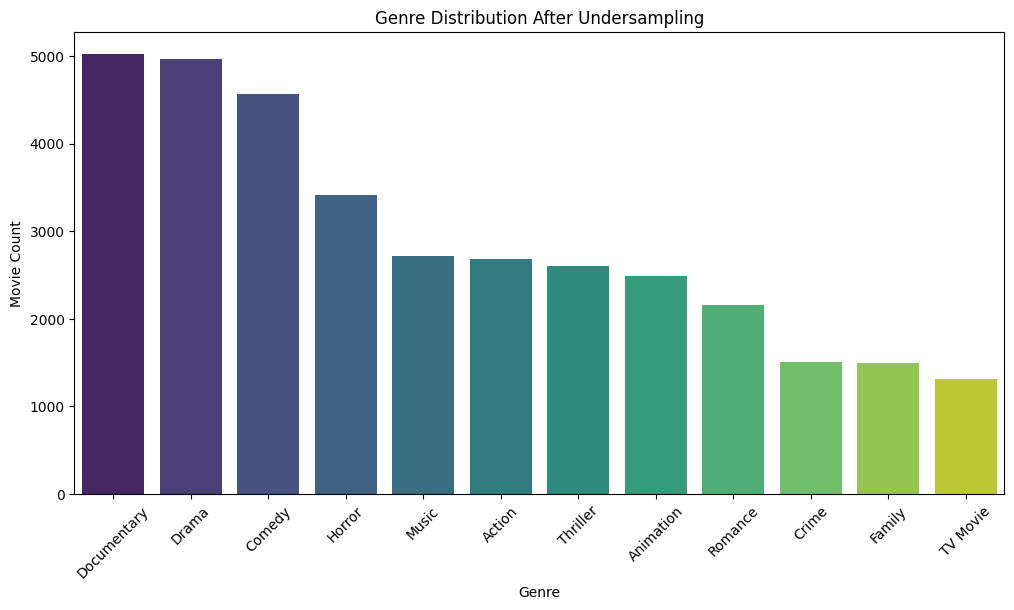

In [ ]:
# Block U3: Plot Genre Distribution After Undersampling

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,6))
sns.barplot(x=new_genre_counts_under.index, y=new_genre_counts_under.values, palette='viridis')
plt.title("Genre Distribution After Undersampling")
plt.xlabel("Genre")
plt.ylabel("Movie Count")
plt.xticks(rotation=45)
plt.show()

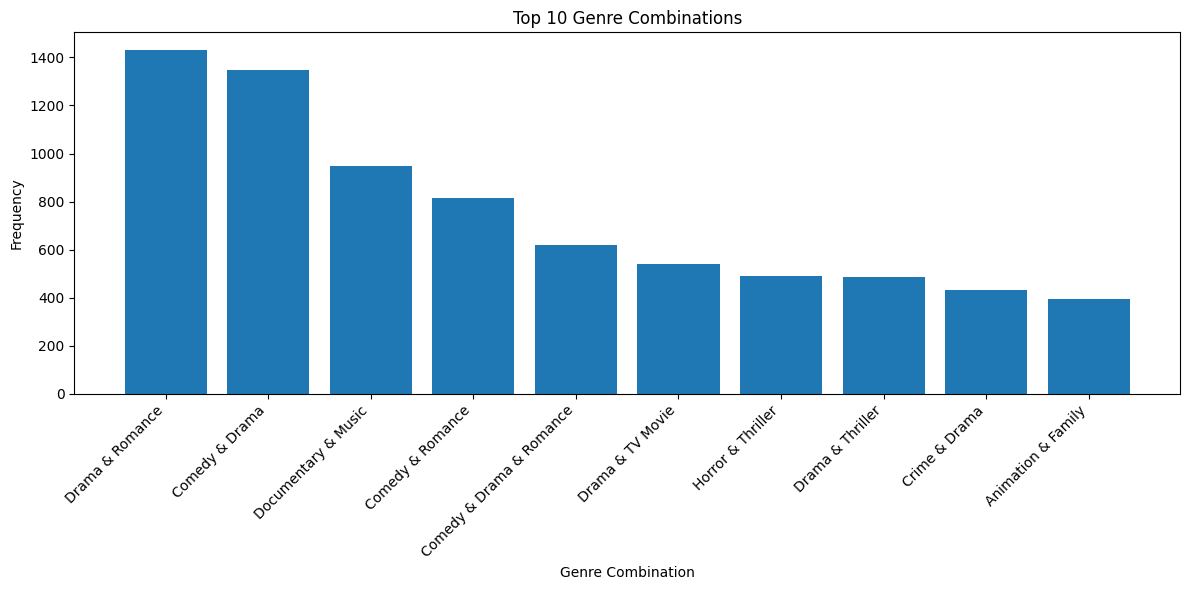

In [ ]:
# 5. Top Genre Combinations with Frequency
from collections import Counter
genre_combos = final_df[final_df[common_genres].sum(axis=1) > 1].apply(
    lambda row: tuple(sorted([genre for genre in common_genres if row[genre] == 1])), axis=1)
combo_counts = Counter(genre_combos)
N = 10
top_combos = combo_counts.most_common(N)
combo_labels = [' & '.join(combo) for combo, _ in top_combos]
combo_freqs = [freq for _, freq in top_combos]
plt.figure(figsize=(12, 6))
plt.bar(combo_labels, combo_freqs)
plt.title(f'Top {N} Genre Combinations')
plt.xlabel('Genre Combination')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('top_genre_combinations.png')

In [ ]:
undersampled_csv = 'undersampled_movie_data.csv'
final_df.to_csv(undersampled_csv, index=False)

#Log-Transformed Distribution of Genre Pair Frequencies'

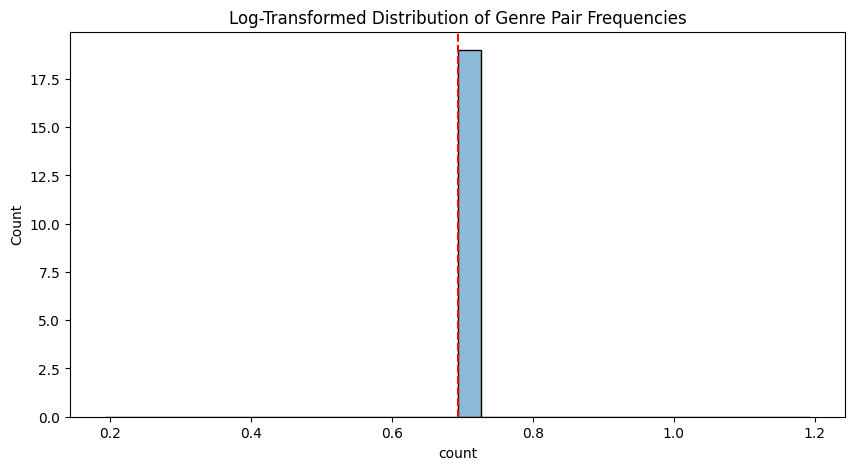

In [ ]:
from scipy.stats import norm
freq_series = pd.Series(genre_pairs).value_counts()

# Apply log transformation
log_freq = np.log1p(freq_series)  # log(1 + x) to handle zeros

# Fit normal distribution to transformed data
mu, sigma = norm.fit(log_freq)
threshold = np.exp(mu + 2*sigma)  # Convert back to original scale

plt.figure(figsize=(10, 5))
sns.histplot(np.log1p(freq_series), bins=30, kde=True)
plt.axvline(mu + 2*sigma, color='red', linestyle='--', label='Log Threshold')
plt.title('Log-Transformed Distribution of Genre Pair Frequencies')
plt.show()

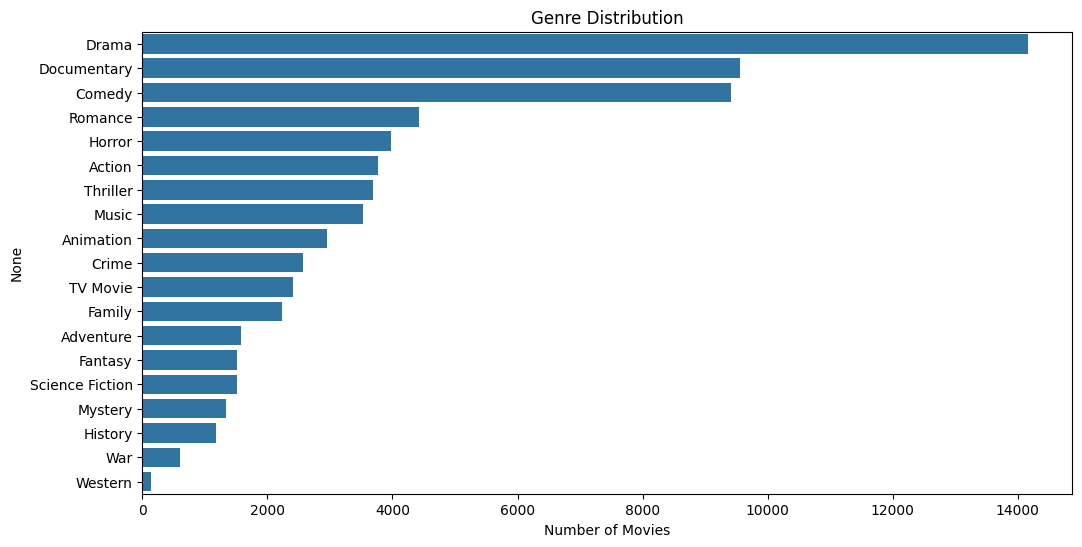

In [ ]:
# Plot genre distribution
genre_counts = genre_df.sum().sort_values(ascending=False)
plt.figure(figsize=(12, 6))
sns.barplot(x=genre_counts.values, y=genre_counts.index)
plt.title('Genre Distribution')
plt.xlabel('Number of Movies')
plt.show()

###Converting text to features
Binary Relevance Problem
If we treat this multi-label classification problem as a Binary Relevance Problem.
One-hot encode the taget variable genres_new by using sklearn's MultiLabelBinarizer(). Since there are 20 unique genre tags, there are going to be 20 new target variables.

`We have also created our target variable or label here`

In [ ]:
y = mlb.fit_transform(final_df['genres'])

###Genre Co-Occurence Heat Map

In [ ]:
corr_matrix = genre_df.corr()
corr_matrix

,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
Action,1.000000,0.247439,0.019634,0.013567,0.187525,-0.129063,0.000729,-0.012081,0.087354,-0.004230,0.004490,-0.071614,-0.004613,-0.021015,0.194326,-0.001289,0.201249,0.035381,0.053691
Adventure,0.247439,1.000000,0.147315,0.045292,-0.002371,-0.071146,-0.036361,0.210044,0.205258,0.010407,-0.020876,-0.036852,0.012750,-0.018616,0.144139,0.019794,0.025684,0.015821,0.034276
Animation,0.019634,0.147315,1.000000,0.011361,-0.047570,-0.110279,-0.126351,0.255805,0.139171,-0.014273,-0.038335,-0.035462,-0.014004,-0.057603,0.114229,-0.016769,-0.063963,-0.010749,0.000277
Comedy,0.013567,0.045292,0.011361,1.000000,-0.003523,-0.205539,-0.016422,0.100636,0.055335,-0.062797,-0.042529,-0.066003,-0.040266,0.172156,0.014195,0.019935,-0.087036,-0.042932,-0.001841
Crime,0.187525,-0.002371,-0.047570,-0.003523,1.000000,-0.100371,0.112028,-0.043327,-0.027498,-0.013581,-0.015271,-0.057934,0.156981,-0.020839,-0.029391,0.053424,0.248452,-0.019718,-0.001275
Documentary,-0.129063,-0.071146,-0.110279,-0.205539,-0.100371,1.000000,-0.298496,-0.095985,-0.081835,0.097996,-0.135516,0.063763,-0.078357,-0.153538,-0.078675,-0.030046,-0.140261,0.021659,-0.019876
Drama,0.000729,-0.036361,-0.126351,-0.016422,0.112028,-0.298496,1.000000,-0.019018,-0.019247,0.053656,-0.123085,-0.119876,0.048909,0.225893,-0.055892,0.087962,0.068104,0.070246,0.008605
Family,-0.012081,0.210044,0.255805,0.100636,-0.043327,-0.095985,-0.019018,1.000000,0.174400,-0.018513,-0.056060,-0.007734,-0.013127,-0.007560,0.030629,0.080635,-0.057739,-0.016000,0.015063
Fantasy,0.087354,0.205258,0.139171,0.055335,-0.027498,-0.081835,-0.019247,0.174400,1.000000,-0.010980,0.052949,-0.022434,0.026385,0.009542,0.117766,0.024649,0.001013,-0.013106,0.000979
History,-0.004230,0.010407,-0.014273,-0.062797,-0.013581,0.097996,0.053656,-0.018513,-0.010980,1.000000,-0.041020,-0.024937,-0.013584,-0.006864,-0.024389,0.049108,-0.027546,0.237465,0.008533


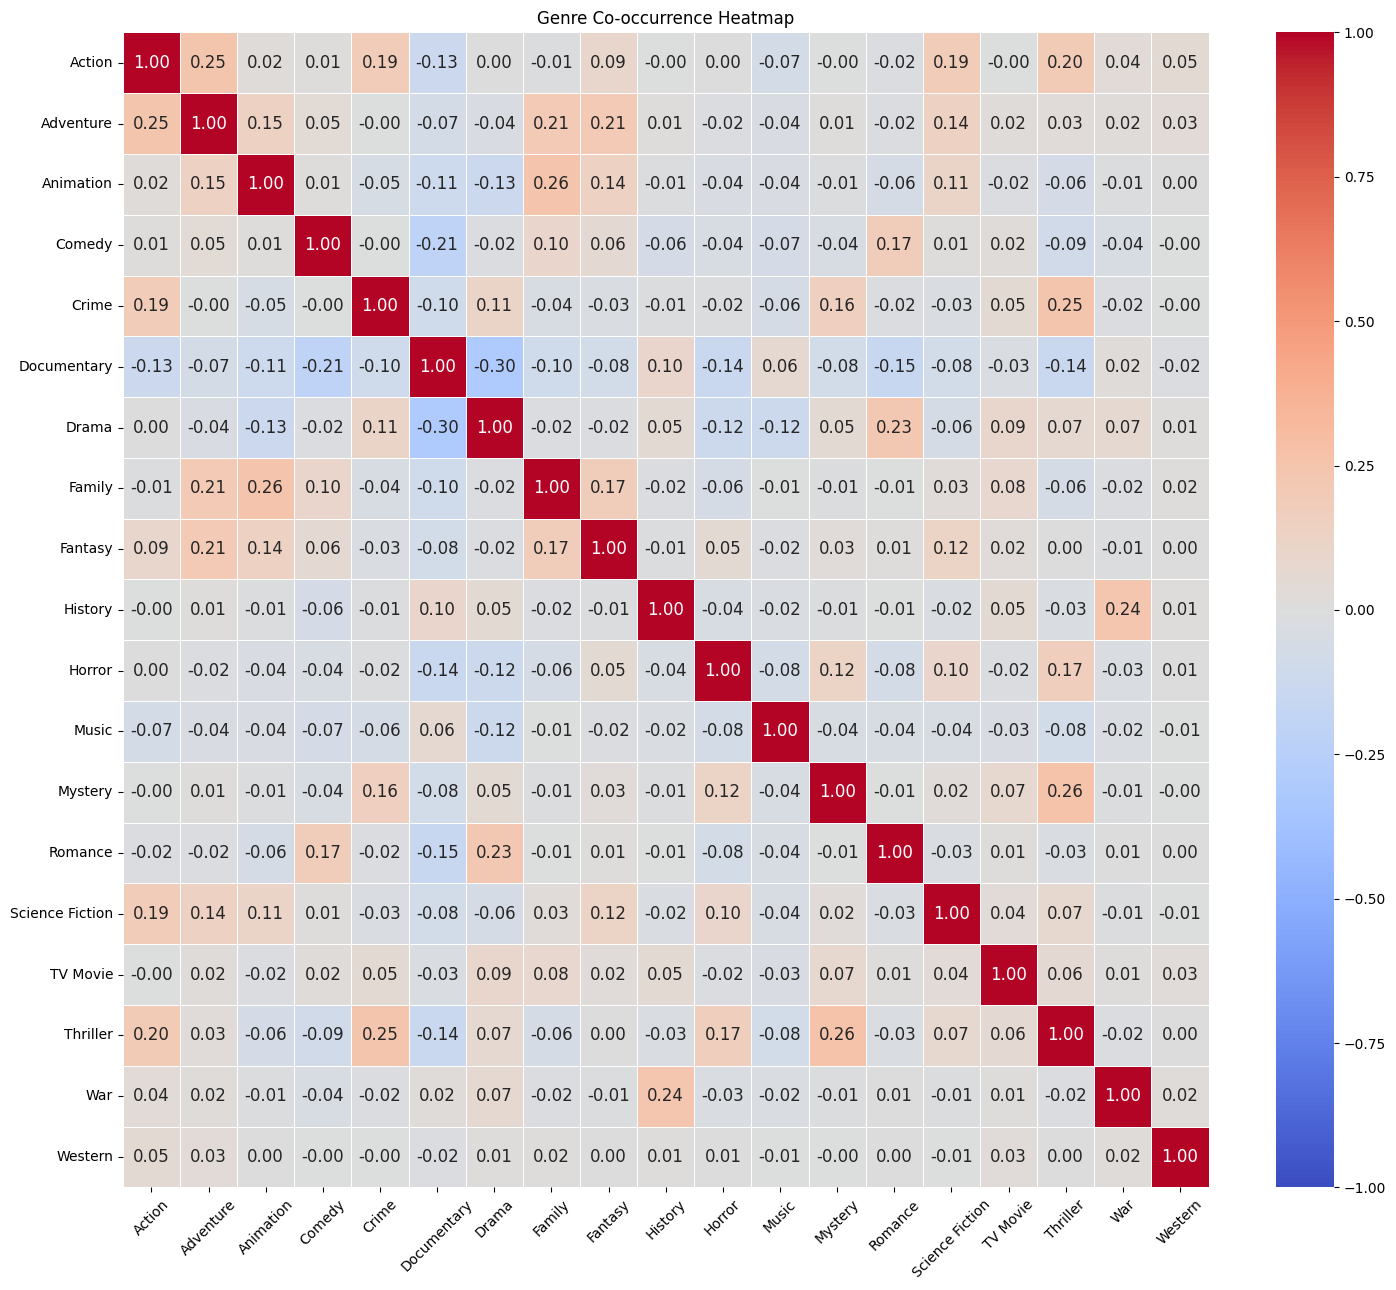

In [ ]:
plt.figure(figsize=(15, 13))
sns.heatmap(
    corr_matrix,
    annot=True,      # Show correlation values
    annot_kws={"size": 12},
    cmap='coolwarm', # Color map
    fmt=".2f",       # Decimal formatting
    linewidths=0.5,
    vmin=-1, vmax=1  # Fix scale for better interpretation
)

plt.title("Genre Co-occurrence Heatmap")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

1. Each cell shows the correlation/co-occurrence between two genres
  * Color Intensity: Warmer colors (red) = stronger positive correlation; cooler colors (blue) = negative/no correlation.
  * Values: Range from -1 to 1 (for correlation) or raw counts (for co-occurrence).
2. Case 1: Strong Positive Correlation (e.g., Family + Animation)
  * Heatmap Value: 0.53
  * Insight: These genres are highly likely to co-occur. Blockbuster movies often combine them.
3. Case 2: Weak/Negative Correlation (e.g., Horror + Romance)
  * Heatmap Value: -0.2

####Total number of genres

In [ ]:
genres = []

for i in final_df['genres']:
  genre_names = [genre for genre in i]
  genres.append(genre_names)

In [ ]:
#get all genre tags in a list
all_genres = sum(genres,[])
total_genres = len(set(all_genres))
total_genres

19

#Text Preprocessing

> Reference: https://medium.com/analytics-vidhya/text-preprocessing-for-nlp-natural-language-processing-beginners-to-master-fd82dfecf95



###Clean the text and remove stopwords function

In [ ]:
#Merging above statements into a function
stop_words = set(stopwords.words('english'))
def clean_Overview(text):
  text = re.sub(r'[^a-zA-Z]',' ', text)
  text = str(text).lower()
  text = word_tokenize(text)
  text = [item for item in text if item not in stop_words]
  text = [lemma.lemmatize(word = w,pos='v') for w in text]
  text = [i for i in text if len(i) > 2]
  text = ' '.join(text)
  return text
final_df['CleanedOverview'] = final_df['overview'].apply(clean_Overview)

In [ ]:
import torch
from collections import Counter
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from collections import defaultdict
from keras.preprocessing.sequence import pad_sequences
from transformers import WordpieceTokenizer

###Feature Extraction - Using Pre-Trained Word Embeddings (GloVe)
* Used to represent words as dense, continuous vectors, capturing their semantic meaning and relationships
* unlike BoW/TF-IDF which treak words as isolated features, WE learn the contextual meaning of words and their similarity to other words



In [ ]:
final_df.head(1)

In [ ]:
#open the .gz file and read it line by line
import gzip
embeddings_index = {}
with gzip.open(embedding_path, 'rt', encoding = 'utf-8') as f:
  for line in f:
    values = line.split()
    word = values[0] #First value is the word
    coefs = torch.tensor(np.asarray(values[1:], dtype='float32'), device=device) #Remaining values are the word embeddings
    embeddings_index[word] = coefs

In [ ]:
print(embeddings_index['computer']) #will return the embedding vector for 'computer'

###Tokenize and pad the text sequences
1. LSTM and Transformer models require fixed length input sequences.
2. The vocabulary (word_index) is created by counting all tokens across all plots.
3. Each tokenized sentence (or plot) is converted to its corresponding word index, using the word_index dictionary.
4. The padding ensures each sequence is padded or truncated to the fixed length of 300.
5. The final padded sequences are converted into a PyTorch tensor (padded_tensor).

In [ ]:
# !pip install torchtext

In [ ]:
# Tokenize the text if not already tokenized
tokenized_texts = [word_tokenize(text.lower()) for text in final_df['CleanedOverview']]

# Create vocabulary (word to index mapping) from tokenized texts
flat_tokens = [token for sublist in tokenized_texts for token in sublist]
token_counts = Counter(flat_tokens)
word_index = {word: idx+1 for idx, (word, _) in enumerate(token_counts.items())}
word_index["<unk>"] = 0  # Add unknown token

# Convert tokenized texts to sequences of indices
sequences = [[word_index.get(word, word_index["<unk>"]) for word in text] for text in tokenized_texts]

# Padding sequences to a fixed length (like maxlen=300)
maxlen = 300
padded_sequences = [seq[:maxlen] if len(seq) > maxlen else seq + [word_index["<unk>"]] * (maxlen - len(seq)) for seq in sequences]

# Convert padded sequences to a tensor
# padded_tensor = torch.tensor(padded_sequences)

In [ ]:
#Create the embedding matrix
embedding_matrix = torch.zeros((len(word_index) + 1, 100))
for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

In [ ]:
embedding_matrix.shape

torch.Size([67771, 100])

In [ ]:
padded_sequences[0]

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 3,
 15,
 16,
 10,
 17,
 18,
 19,
 20,
 1,
 21,
 22,
 23,
 24,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


###Define the model, compile, and create train and test split

In [ ]:
#convert padded sequence and y (one hot encoded genres) to tensor
X = torch.tensor(padded_sequences, dtype=torch.long, device=device)
y_lstm = torch.tensor(y, dtype=torch.float32, device=device)

#Split the data into trainig and validation sets
X_train,X_val,y_train, y_val = train_test_split(X, y_lstm, test_size=0.2, random_state=9)
X_train, y_train = X_train.to(device), y_train.to(device)
X_val, y_val = X_val.to(device), y_val.to(device)

In [ ]:
y.shape

(40558, 19)

###Create DataLoader for batch processing

In [ ]:
train_data = TensorDataset(X_train, y_train)
val_data = TensorDataset(X_val, y_val)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)

##LSTM Model

In [ ]:
class EmbeddingLayer(nn.Module):
    def __init__(self, vocab_size, embedding_dim, embedding_matrix):
        super(EmbeddingLayer, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(embedding_matrix), freeze=True)



    def forward(self, input_seq):
        return self.embedding(input_seq)

In [ ]:
# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_matrix, embedding_dim, hidden_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.embedding_layer = EmbeddingLayer(vocab_size, embedding_dim, embedding_matrix)
        self.lstm_layer = nn.LSTM(embedding_dim, hidden_dim, num_layers=1, batch_first=True)
        # self.dropout_layer = nn.Dropout(0.3)  # Add dropout with a dropout rate of 0.2
        self.fc_layer = nn.Linear(hidden_dim, output_dim)

    def forward(self, input_seq):
        embedded_seq = self.embedding_layer(input_seq)
        lstm_output, _ = self.lstm_layer(embedded_seq)
        # lstm_output = self.dropout_layer(lstm_output)  # Apply dropout to the LSTM output
        output = self.fc_layer(lstm_output[:, -1, :])
        return output

###Setting the Hyperparameters

In [ ]:
vocab_size = len(word_index) + 1
embedding_dim = 100
hidden_dim = 256
output_dim = total_genres  # Number of genres (multilabel classification)

###Initialize the model

In [ ]:
# Initialize the model, loss function, and optimizer
model = LSTMModel(vocab_size=vocab_size,embedding_matrix=embedding_matrix, embedding_dim=embedding_dim, hidden_dim=hidden_dim, output_dim=output_dim)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
model.to(device)

LSTMModel(
  (embedding_layer): EmbeddingLayer(
    (embedding): Embedding(67771, 100)
  )
  (lstm_layer): LSTM(100, 256, batch_first=True)
  (fc_layer): Linear(in_features=256, out_features=19, bias=True)
)

###Training the model

In [ ]:
# Define the training and evaluation functions
def train(model, device, train_loader, optimizer, criterion):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_targets = []
    for batch_idx, (data, target) in enumerate(train_loader):
      data, target = data.to(device), target.to(device)
      optimizer.zero_grad()
      output = model(data)
      loss = criterion(output, target)
      loss.backward()
      optimizer.step()
      total_loss += loss.item()

      # Apply sigmoid + threshold for multi-label prediction
      preds = torch.sigmoid(output) > 0.5  # binary predictions
      correct += (preds == target.bool()).sum().item()
      total += target.numel()
    all_preds.extend(preds.cpu().numpy().flatten())
    all_targets.extend(target.cpu().numpy().flatten())

    accuracy = correct / total
    f1_micro = f1_score(all_targets, all_preds, average='micro')
    f1_macro = f1_score(all_targets, all_preds, average='macro')
    print(f'Training Loss: {total_loss / (batch_idx + 1)}')
    print(f'Train Accuracy (per label): {accuracy * 100:.2f}%')
    return accuracy, f1_micro, f1_macro

In [ ]:
from sklearn.metrics import f1_score

def evaluate(model, device, val_loader, criterion):
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
      all_preds = []
      all_targets = []
      for data, target in val_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        loss = criterion(output, target)
        val_loss += loss.item()

        # Apply sigmoid + threshold for multi-label prediction
        preds = torch.sigmoid(output) > 0.5  # binary predictions
        correct += (preds == target.bool()).sum().item()
        total += target.numel()
    all_preds.extend(preds.cpu().numpy().flatten())
    all_targets.extend(target.cpu().numpy().flatten())

    accuracy = correct / total
    f1_micro = f1_score(all_targets, all_preds, average='micro')
    f1_macro = f1_score(all_targets, all_preds, average='macro')
    print(f'Validation Loss: {val_loss / len(val_loader):.4f}')
    print(f'Validation Accuracy (per label): {accuracy * 100:.2f}%')
    print(f'Validation F1 Score (micro): {f1_micro:.4f}')
    print(f'Validation F1 Score (macro): {f1_macro:.4f}')
    return accuracy, f1_micro, f1_macro

In [ ]:
stop =

In [ ]:
# Train the model
epochs = 10
num_epochs = []
train_acc, val_acc = [], []
train_f1_micro, val_f1_micro = [], []
train_f1_macro, val_f1_macro = [], []

for epoch in range(epochs):
    print(f"Epoch {epoch}")
    num_epochs.append(epoch)
    t_acc, t_f1_micro, t_f1_macro = train(model, device, train_loader, optimizer, criterion)
    train_acc.append(t_acc)
    train_f1_micro.append(t_f1_micro)
    train_f1_macro.append(t_f1_macro)
    v_acc, v_f1_micro, v_f1_macro = evaluate(model, device, val_loader, criterion)
    val_acc.append(v_acc)
    val_f1_micro.append(v_f1_micro)
    val_f1_macro.append(v_f1_macro)

Epoch 0
Training Loss: 0.31597465326682583
Train Accuracy (per label): 88.79%
Validation Loss: 0.2672
Validation Accuracy (per label): 90.87%
Validation F1 Score (micro): 0.9156
Validation F1 Score (macro): 0.4780
Epoch 1
Training Loss: 0.2694373156662288
Train Accuracy (per label): 90.83%
Validation Loss: 0.2674
Validation Accuracy (per label): 90.87%
Validation F1 Score (micro): 0.9156
Validation F1 Score (macro): 0.4780
Epoch 2
Training Loss: 0.2694545576323184
Train Accuracy (per label): 90.83%
Validation Loss: 0.2672
Validation Accuracy (per label): 90.87%
Validation F1 Score (micro): 0.9156
Validation F1 Score (macro): 0.4780
Epoch 3
Training Loss: 0.269445177806905
Train Accuracy (per label): 90.83%
Validation Loss: 0.2672
Validation Accuracy (per label): 90.87%
Validation F1 Score (micro): 0.9156
Validation F1 Score (macro): 0.4780
Epoch 4
Training Loss: 0.26945964204371564
Train Accuracy (per label): 90.83%
Validation Loss: 0.2671
Validation Accuracy (per label): 90.87%
Valida

#Movie Prediction function

In [ ]:
import random
def predict_movie(model, device, val_loader):
    # Get a random index from the validation set
    random_idx = random.randint(0, len(val_loader) - 1)
    data, target = next(iter(val_loader))
    data, target = data.to(device), target.to(device)

    # Get the predicted labels
    output = model(data)
    _, predicted = torch.max(output, 1)

    # Convert the predicted labels to strings
    predicted_labels = final_df['genres'][predicted[0].item()]

    # Print the movie overview, actual labels, and predicted labels
    print("Movie Title:", final_df['title'][random_idx])
    print("Movie Overview:", final_df['CleanedOverview'][random_idx])
    actual_label = final_df['genres'][random_idx]
    print("Actual Labels:", actual_label)
    print("Predicted Labels:", predicted_labels)

# Call the function
predict_movie(model, device, val_loader)

Movie Title: Little Nicky
Movie Overview: lord darkness decide cede throne three sons two powerful escape earth create kingdom action close portal filter sinful souls hell cause satan wither away must send weak beloved son little nicky earth return brothers hell
Actual Labels: ['Comedy', 'Fantasy']
Predicted Labels: ['Adventure', 'Action', 'Thriller']


#Plotting the data

In [ ]:
def plot_acc(num_of_epochs,train_acc,valid_acc):
  plt.figure(figsize=(10,8))
  plt.plot(num_of_epochs, train_acc, label = "Training Accuracy")
  plt.plot(num_of_epochs,valid_acc, label = "Validation Accuracy")
  plt.title(f'Accuracy vs. Epochs')
  plt.xlabel("Number of Epochs")
  plt.ylabel("Accuracy")
  plt.legend();

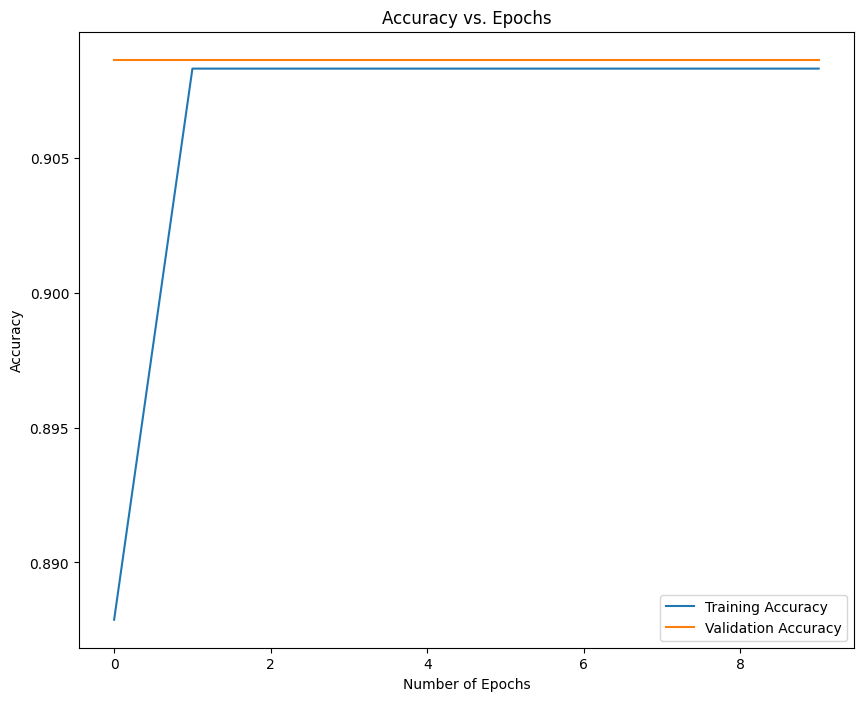

In [ ]:
plot_acc(num_epochs, train_acc, val_acc) #1e-3

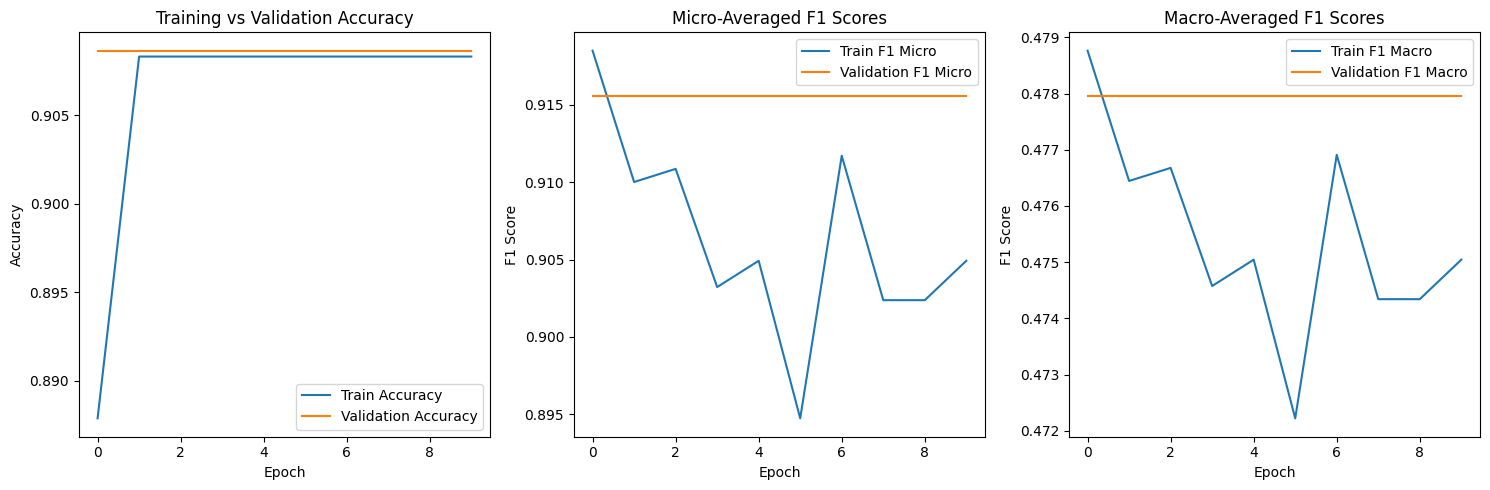

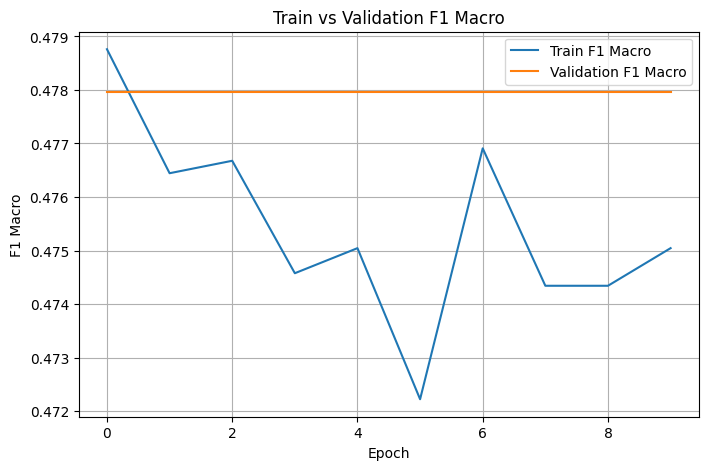

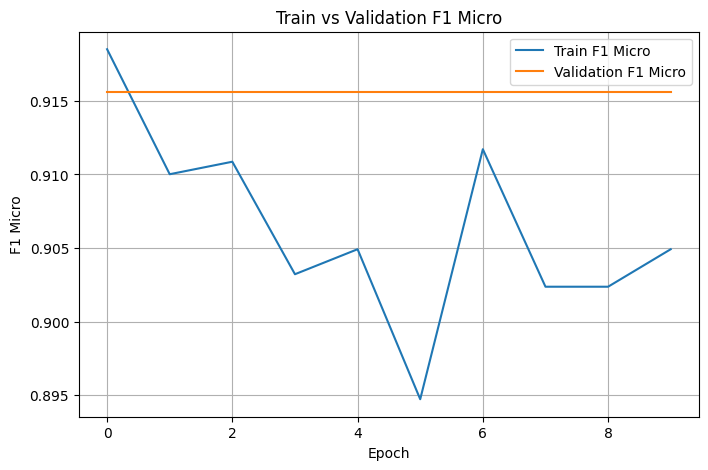

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_training_metrics(num_epochs, train_acc, val_acc,
                         train_f1_micro, val_f1_micro,
                         train_f1_macro, val_f1_macro):
    """
    Plot accuracy and F1 scores (micro/macro) across epochs
    """
    plt.figure(figsize=(15, 5))

    # 1. Accuracy Plot
    plt.subplot(1, 3, 1)
    plt.plot(num_epochs, train_acc, label='Train Accuracy')
    plt.plot(num_epochs, val_acc, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.legend()

    # 2. F1 Micro Plot
    plt.subplot(1, 3, 2)
    plt.plot(num_epochs, train_f1_micro, label='Train F1 Micro')
    plt.plot(num_epochs, val_f1_micro, label='Validation F1 Micro')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.title('Micro-Averaged F1 Scores')
    plt.legend()

    # 3. F1 Macro Plot
    plt.subplot(1, 3, 3)
    plt.plot(num_epochs, train_f1_macro, label='Train F1 Macro')
    plt.plot(num_epochs, val_f1_macro, label='Validation F1 Macro')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.title('Macro-Averaged F1 Scores')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Add this after your training loop:
plot_training_metrics(num_epochs, train_acc, val_acc,
                     train_f1_micro, val_f1_micro,
                     train_f1_macro, val_f1_macro)

# Additional diagnostic plots
def plot_metric_comparison(num_epochs, train_metrics, val_metrics, metric_name):
    plt.figure(figsize=(8, 5))
    plt.plot(num_epochs, train_metrics, label=f'Train {metric_name}')
    plt.plot(num_epochs, val_metrics, label=f'Validation {metric_name}')
    plt.xlabel('Epoch')
    plt.ylabel(metric_name)
    plt.title(f'Train vs Validation {metric_name}')
    plt.legend()
    plt.grid(True)
    plt.show()

# Compare macro vs micro F1
plot_metric_comparison(num_epochs, train_f1_macro, val_f1_macro, 'F1 Macro')
plot_metric_comparison(num_epochs, train_f1_micro, val_f1_micro, 'F1 Micro')